# Implementing Sentiment Analysis Using Simple LSTM

In [1]:
# Importing packages
import re
import string
import numpy as np
import pandas as pd
import tensorflow 
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


In [ ]:
# Importing the dataset
df = pd.read_csv("Data/IMDB Dataset.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data Preprocessing

In [ ]:
#removing the html
def clean_html(text):
    clean =re.compile('<.*?>')
    clean_text = re.sub(clean, '', text)
    return clean_text

In [ ]:
# first round of cleaning
def clean_text1(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]'%re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '' , text)
    return text

In [ ]:
# second round of cleaning
def clean_text2(text):
    text = re.sub('['',"",,,]', '' ,text)
    text = re.sub('\n', '', text)
    return text

In [ ]:
df['review_cleaned'] = pd.DataFrame(df.review.apply(lambda x : clean_html(x)))
df['review_cleaned'] = pd.DataFrame(df.review_cleaned.apply(lambda x : clean_text1(x)))
df['review_cleaned'] = pd.DataFrame(df.review_cleaned.apply(lambda x : clean_text2(x)))

In [ ]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

## Preparing the Data

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trun_type = 'post'

num_epochs = 30

In [ ]:
tokenizer = Tokenizer(num_words= vocab_size, split= ' ')
tokenizer.fit_on_texts(df['review_cleaned'].values)


In [ ]:
X = tokenizer.texts_to_sequences(df['review_cleaned'].values)
X= pad_sequences(X, maxlen= max_length, truncating= trun_type)

In [ ]:
Y = pd.get_dummies(df['sentiment'], drop_first= True)

In [ ]:
Y = to_categorical(Y, dtype= 'uint8')

In [ ]:
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

## Defining the Model 

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length= max_length),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(2, activation= 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 180866 (706.51 KB)
Trainable params: 180866 (706.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer= 'adam',
              metrics = ['accuracy'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size= 0.2, stratify= Y, random_state= 317)

In [ ]:
X_train.shape, y_train.shape

((40000, 120), (40000, 2))

In [ ]:
X_test.shape, y_test.shape

((10000, 120), (10000, 2))

In [ ]:
history = model.fit(X_train,y_train, 
                    epochs= num_epochs,
                    validation_data = (X_test, y_test)
                    )

Epoch 1/30
1250/1250 [==============================] - 104s 77ms/step - loss: 0.4262 - accuracy: 0.8025 - val_loss: 0.3527 - val_accuracy: 0.8485
Epoch 2/30
1250/1250 [==============================] - 96s 76ms/step - loss: 0.3036 - accuracy: 0.8784 - val_loss: 0.3646 - val_accuracy: 0.8415
Epoch 3/30
1250/1250 [==============================] - 97s 77ms/step - loss: 0.2620 - accuracy: 0.8972 - val_loss: 0.3780 - val_accuracy: 0.8386
Epoch 4/30
1250/1250 [==============================] - 96s 77ms/step - loss: 0.2228 - accuracy: 0.9131 - val_loss: 0.3934 - val_accuracy: 0.8300
Epoch 5/30
1250/1250 [==============================] - 97s 77ms/step - loss: 0.1961 - accuracy: 0.9241 - val_loss: 0.4993 - val_accuracy: 0.8370
Epoch 6/30
1250/1250 [==============================] - 97s 78ms/step - loss: 0.1593 - accuracy: 0.9414 - val_loss: 0.5260 - val_accuracy: 0.8315
Epoch 7/30
1250/1250 [==============================] - 97s 78ms/step - loss: 0.1379 - accuracy: 0.9502 - val_loss: 0.6064 

In [ ]:
def plot_graph_stats(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("num_epochs")
    plt.ylabel(string)
    plt.legend([string, 'val'+string])
    plt.show()


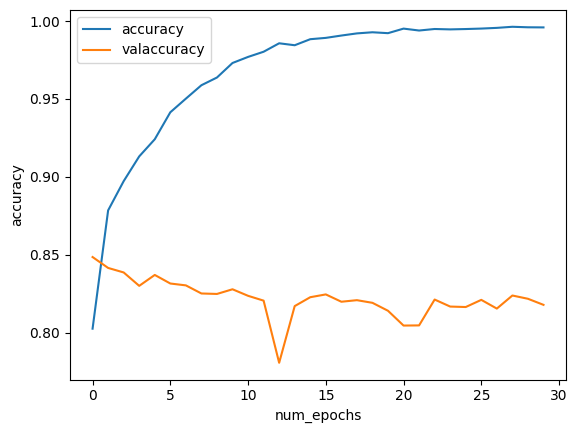

In [ ]:
plot_graph_stats(history, 'accuracy')

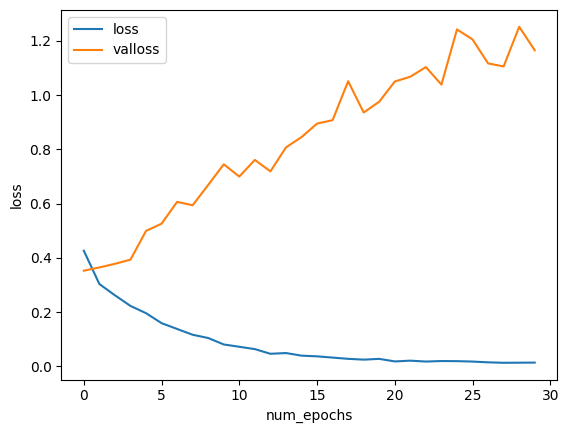

In [ ]:
plot_graph_stats(history, 'loss')

In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length= max_length),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation= 'softmax')
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                20736     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 180866 (706.51 KB)
Trainable params: 180866 (706.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
history_2 = model_2.fit(X_train,y_train,
                    epochs= num_epochs,
                    validation_data = (X_test, y_test),
                     batch_size=128, callbacks=[early_stop])


Epoch 1/30
313/313 [==============================] - 64s 180ms/step - loss: 0.4688 - accuracy: 0.7661 - val_loss: 0.3580 - val_accuracy: 0.8425
Epoch 2/30
313/313 [==============================] - 47s 151ms/step - loss: 0.3043 - accuracy: 0.8780 - val_loss: 0.3681 - val_accuracy: 0.8483
Epoch 3/30
313/313 [==============================] - 47s 149ms/step - loss: 0.2698 - accuracy: 0.8952 - val_loss: 0.3782 - val_accuracy: 0.8452
Epoch 4/30
313/313 [==============================] - 48s 155ms/step - loss: 0.2465 - accuracy: 0.9054 - val_loss: 0.3754 - val_accuracy: 0.8367
Epoch 5/30
313/313 [==============================] - 49s 156ms/step - loss: 0.2184 - accuracy: 0.9157 - val_loss: 0.5074 - val_accuracy: 0.8372
Epoch 6/30
313/313 [==============================] - 48s 152ms/step - loss: 0.1976 - accuracy: 0.9262 - val_loss: 0.3992 - val_accuracy: 0.8323


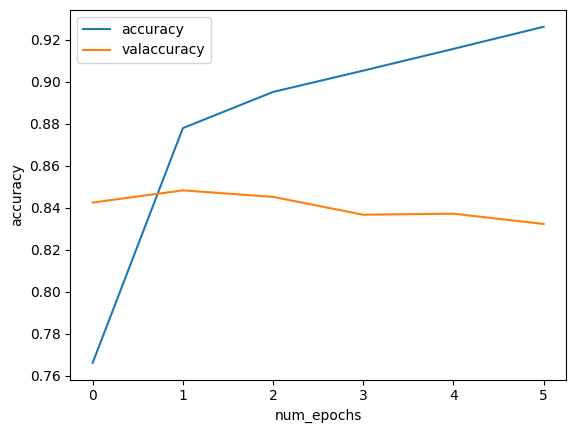

In [ ]:
plot_graph_stats(history_2, 'accuracy')

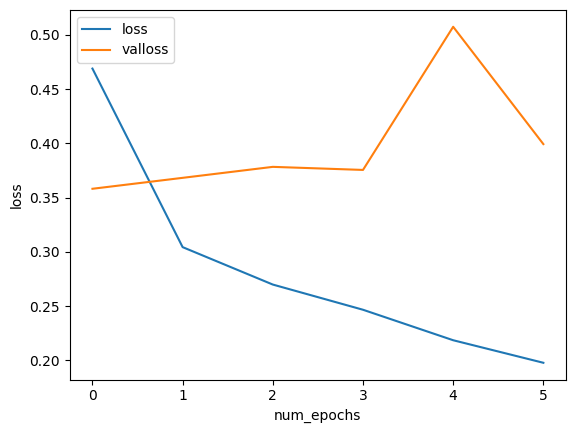

In [ ]:
plot_graph_stats(history_2, 'loss')

In [ ]:
# Evaluate the model
loss, accuracy = model_2.evaluate(X_test, y_test)

313/313 [==============================] - 8s 25ms/step - loss: 0.3580 - accuracy: 0.8425
